In [10]:
###################################################################################################
#
# PairIdentification.py
#
# Copyright (C) by Andreas Zoglauer & Harrison Costatino.
#
# Please see the file LICENSE in the main repository for the copyright-notice.
#
###################################################################################################



###################################################################################################

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt

import random

import signal
import sys
import time
import math
import csv
import os
import argparse
import logging
import yaml
from datetime import datetime
from functools import reduce


print("\nPair Identification")
print("============================\n")



# Step 1: Input parameters
###################################################################################################


# Default parameters

# Split between training and testing data
TestingTrainingSplit = 0.1

MaxEvents = 1000

# File names
FileName = "PairIdentification.p1.sim.gz"
GeometryName = "$(MEGALIB)/resource/examples/geomega/GRIPS/GRIPS.geo.setup"


# Set in stone later
TestingTrainingSplit = 0.8

OutputDirectory = "Results"


parser = argparse.ArgumentParser(description='Perform training and/or testing of the pair identification machine learning tools.')
parser.add_argument('-d', '--datatype', default='tm2', help='One of: tm1: toy modle #1, tm2: toy model #2, f: file')
parser.add_argument('-f', '--filename', default='PairIdentification.p1.sim.gz', help='File name used for training/testing')
parser.add_argument('-m', '--maxevents', default='100', help='Maximum number of events to use')
parser.add_argument('-s', '--testingtrainigsplit', default='0.1', help='Testing-training split')
parser.add_argument('-b', '--batchsize', default='16', help='Batch size')

# Command line arguments for build model, to remove dependency on .yaml
parser.add_argument('--model_type', default='gnn_segment_classifier', help='model_type')
parser.add_argument('--optimizer', default='Adam', help='optimizer')
parser.add_argument('--learning_rate', default='0.001', help='learning_rate')
parser.add_argument('--loss_func', default='BCELoss', help='loss_func')
parser.add_argument('--input_dim', default='3', help='input_dim')
parser.add_argument('--hidden_dim', default='64', help='hidden_dim')
parser.add_argument('--n_iters', default='100', help='n_iters')
# parser.add_argument('--hidden_activation', default='nn.Tanh', help='hidden_activation')


args = parser.parse_args()

DataType = args.datatype

if args.filename != "":
  FileName = args.filename

if int(args.maxevents) >= 10:
  MaxEvents = int(args.maxevents)

if int(args.batchsize) >= 0:
  BatchSize = int(args.batchsize)

if float(args.testingtrainigsplit) >= 0.05:
  TestingTrainingSplit = float(args.testingtrainigsplit)


if os.path.exists(OutputDirectory):
  Now = datetime.now()
  OutputDirectory += Now.strftime("_%Y%m%d_%H%M%S")

os.makedirs(OutputDirectory)



###################################################################################################
# Step 2: Global functions
###################################################################################################


# Take care of Ctrl-C
Interrupted = False
NInterrupts = 0
def signal_handler(signal, frame):
  global Interrupted
  Interrupted = True
  global NInterrupts
  NInterrupts += 1
  if NInterrupts >= 2:
    print("Aborting!")
    sys.exit(0)
  print("You pressed Ctrl+C - waiting for graceful abort, or press  Ctrl-C again, for quick exit.")
signal.signal(signal.SIGINT, signal_handler)


# Everything ROOT related can only be loaded here otherwise it interferes with the argparse
from EventData import EventData

# Load MEGAlib into ROOT so that it is usable
import ROOT as M
M.gSystem.Load("$(MEGALIB)/lib/libMEGAlib.so")
M.PyConfig.IgnoreCommandLineOptions = True



###################################################################################################
# Step 3: Create some training, test & verification data sets
###################################################################################################


# Read the simulation file data:
DataSets = []
NumberOfDataSets = 0

if DataType == "tm1":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel1(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "tm2":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel2(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "f":
  # Load geometry:
  Geometry = M.MDGeometryQuest()
  if Geometry.ScanSetupFile(M.MString(GeometryName)) == True:
    print("Geometry " + GeometryName + " loaded!")
  else:
    print("Unable to load geometry " + GeometryName + " - Aborting!")
    quit()


  Reader = M.MFileEventsSim(Geometry)
  if Reader.Open(M.MString(FileName)) == False:
    print("Unable to open file " + FileName + ". Aborting!")
    quit()


  print("\n\nStarted reading data sets")
  NumberOfDataSets = 0
  while NumberOfDataSets < MaxEvents:
    Event = Reader.GetNextEvent()
    if not Event:
      break

    if Event.GetNIAs() > 0:
      Data = EventData()
      if Data.parse(Event) == True:
        if Data.hasHitsOutside(XMin, XMax, YMin, YMax, ZMin, ZMax) == False:
          DataSets.append(Data)
          NumberOfDataSets += 1
          if NumberOfDataSets % 500 == 0:
            print("Data sets processed: {}".format(NumberOfDataSets))

else:
  print("Unknown data type \"{}\" Must be one of tm1, tm2, f".format(DataType))
  quit()

print("Info: Parsed {} events".format(NumberOfDataSets))

# Split the data sets in training and testing data sets

TestingTrainingSplit = 0.75


numEvents = len(DataSets)

numTraining = int(numEvents * TestingTrainingSplit)

TrainingDataSets = DataSets[:numTraining]
TestingDataSets = DataSets[numTraining:]



# For testing/validation split
# ValidationDataSets = TestingDataSets[:int(len(TestingDataSets)/2)]
# TestingDataSets = TestingDataSets[int(len(TestingDataSets)/2):]

print("###### Data Split ########")
print("Training/Testing Split: {}".format(TestingTrainingSplit))
print("Total Data: {}, Training Data: {},Testing Data: {}".format(numEvents, len(TrainingDataSets), len(TestingDataSets)))
print("##########################")


###################################################################################################
# Step 4: Vectorize data using preprocess.py
###################################################################################################

from preprocess import generate_incidence, connect_pos, vectorize_data
import torch
import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

# Locals
from datasets import get_data_loaders
from trainers import get_trainer

train_Edge_Labels, train_Man_Ri, train_Man_Ro, train_XYZ, train_Type, train_Energy, train_GammaEnergy, train_True_Ri, train_True_Ro = vectorize_data(TrainingDataSets)
test_Edge_Labels, test_Man_Ri, test_Man_Ro, test_XYZ, test_Type, test_Energy, test_GammaEnergy, test_True_Ri, test_True_Ro = vectorize_data(TestingDataSets)

train_features = [[train_XYZ[i], train_Man_Ri[i], train_Man_Ro[i]] for i in range(train_XYZ.shape[0])]
train_labels = train_Edge_Labels

test_features = [[test_XYZ[i], test_Man_Ri[i], test_Man_Ro[i]] for i in range(test_XYZ.shape[0])]
test_labels = test_Edge_Labels

train_dataset = [[train_features[i],train_labels[i]] for i in range(train_XYZ.shape[0])]
test_dataset = [[test_features[i],test_labels[i]] for i in range(test_XYZ.shape[0])] 

train_data_loader = DataLoader(train_dataset, batch_size=BatchSize)
valid_data_loader = DataLoader(test_dataset, batch_size=BatchSize)


Pair Identification

Added Bremsstrahlung hits
Eliminate hit 8 at 19.266040859171582 0.13326673184839888 -6.0
Event ID: 0
  Origin Z: -5
  Gamma Energy: 10000.0
  Hit 1 (origin: 0): type=e, pos=(19.757659063985603, -0.6697414949823832, -5.0)cm, E=509.1313580294361keV
  Hit 2 (origin: 1): type=e, pos=(12.213707434350649, -2.4374885564275157, -4.0)cm, E=724.9565279921848keV
  Hit 3 (origin: 2): type=e, pos=(11.668986494717814, -1.76771714089988, -3.0)cm, E=781.3725556943533keV
  Hit 4 (origin: 3): type=e, pos=(10.959825755955826, -1.5915509963889816, -2.0)cm, E=824.7771537949194keV
  Hit 5 (origin: 4): type=e, pos=(10.989394187309124, -1.9790265551564636, -1.0)cm, E=878.688756277273keV
  Hit 6 (origin: 5): type=e, pos=(8.847786637015856, -2.0447583592405936, 0.0)cm, E=924.797981213962keV
  Hit 7 (origin: 6): type=e, pos=(8.879859057134048, -1.9943874671244857, 1.0)cm, E=556.3840841517354keV
  Hit 8 (origin: 1): type=p, pos=(20.44108391152358, 3.1755923660863914, -7.0)cm, E=761.846928280

  Hit 1 (origin: 0): type=e, pos=(4.992086748748189, 15.743151049893518, 17.0)cm, E=820.7826262501287keV
  Hit 2 (origin: 1): type=e, pos=(6.022770066630408, 15.701607931352816, 16.0)cm, E=864.2766433281802keV
  Hit 3 (origin: 2): type=e, pos=(5.807180128205521, 15.549621355685352, 15.0)cm, E=913.4968853810032keV
  Hit 4 (origin: 3): type=e, pos=(1.9678448597520717, 19.275169317896577, 14.0)cm, E=676.5976272763622keV
  Hit 5 (origin: 0): type=p, pos=(3.4749392097041447, 18.060332424752378, 19.0)cm, E=598.5167611352077keV
  Hit 6 (origin: 5): type=p, pos=(2.8548505885804536, 18.55117989911253, 20.0)cm, E=688.6757684781525keV
  Hit 7 (origin: 6): type=p, pos=(3.164101140248031, 18.87879689857268, 21.0)cm, E=753.5621284629959keV
  Hit 8 (origin: 7): type=p, pos=(2.885183254564532, 16.787239539367462, 22.0)cm, E=790.7270679783907keV
  Hit 9 (origin: 8): type=p, pos=(1.7755887794135325, 19.143003756930025, 23.0)cm, E=846.2363914738045keV
  Hit 10 (origin: 9): type=p, pos=(1.1089081761741104

In [11]:
###################################################################################################
# Step 5: Setting up the neural network
###################################################################################################

# trainer = get_trainer(distributed=args.distributed, output_dir=output_dir,
#                           device=args.device, **experiment_config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", "cuda:0" if torch.cuda.is_available() else "cpu", "for training.")

trainer = get_trainer(name='gnn', device=device)

# Build the model
# trainer.build_model(**model_config)

'''
model_config:
    model_type: 'gnn_segment_classifier'
    input_dim: 3
    hidden_dim: 64
    n_iters: 4
    loss_func: 'BCELoss'
    optimizer: 'Adam'
    learning_rate: 0.001
'''
model_type = args.model_type
optimizer = args.optimizer
learning_rate = float(args.learning_rate)
loss_func = args.loss_func
input_dim = int(args.input_dim)
hidden_dim = int(args.hidden_dim)
n_iters = 5

trainer.build_model(model_type=model_type, optimizer=optimizer, learning_rate=learning_rate, loss_func=loss_func, 
  input_dim=3, hidden_dim=hidden_dim, n_iters=n_iters)

# if not args.distributed or (dist.get_rank() == 0):
#     trainer.print_model_summary()

###################################################################################################
# Step 6: Training the network
###################################################################################################

summary = trainer.train(train_data_loader=train_data_loader,
                        valid_data_loader=valid_data_loader, n_epochs=n_iters)

print('Train Loss Log: ', summary['train_loss'])
print('Final Test Accuracy: ', summary['valid_acc'][-1])
print('Max Test Accuracy: ', max(summary['valid_acc']))


trainer.write_summaries("Results/result", summary)

###################################################################################################
# Step 7: Evaluating the network
###################################################################################################



Using cpu for training.
Ported Model to Device
Finished Building Model
Batch 0 Loss: 0.6629796028137207
Batch 1 Loss: 0.683466374874115
Batch 2 Loss: 0.6729647517204285
Batch 3 Loss: 0.6668699383735657
Batch 4 Loss: 0.6735877990722656
Batch 0 Loss: 0.6375240683555603
Batch 1 Loss: 0.6622654795646667
Batch 2 Loss: 0.6536635160446167
Batch 3 Loss: 0.6509588360786438
Batch 4 Loss: 0.6384834051132202
Batch 0 Loss: 0.6233314871788025
Batch 1 Loss: 0.6482369899749756
Batch 2 Loss: 0.6316163539886475
Batch 3 Loss: 0.6359979510307312
Batch 4 Loss: 0.6054126024246216
Batch 0 Loss: 0.6063519716262817
Batch 1 Loss: 0.6299991607666016
Batch 2 Loss: 0.6092444658279419
Batch 3 Loss: 0.6183449625968933
Batch 4 Loss: 0.5776441097259521
Batch 0 Loss: 0.5899502038955688
Batch 1 Loss: 0.606785774230957
Batch 2 Loss: 0.5867729187011719
Batch 3 Loss: 0.5990607738494873
Batch 4 Loss: 0.5589656829833984
Train Loss Log:  [0.6719736933708191, 0.6485790610313416, 0.6289190769195556, 0.6083169341087341, 0.588307

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


def draw_vertices_xy(points):
    plt.plot(points[:, 0], points[:, 1], 'o', c='black')

def draw_edge_xy(ptA, ptB, color="blue"):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    line = plt.plot(x_coords, y_coords, color)[0]
#     add_arrow(line)
#     if correct:
#         line = plt.plot(x_coords, y_coords, 'green')[0]
#         # add_arrow(line)
#     else:
#         line = plt.plot(x_coords, y_coords, 'red')[0]
#         # add_arrow(line)

def draw_edge_xyz(ptA, ptB, color="blue"):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    z_coords = np.array([ptA[2], ptB[2]])

    line = plt.plot(x_coords, y_coords, z_coords, color)[0]
#     if correct:
#         line = plt.plot(x_coords, y_coords, z_coords, 'green')[0]
# #         add_arrow(line)
#     else:
#         line = plt.plot(x_coords, y_coords, z_coords, 'red')[0]
# #         add_arrow(line)


"""
pos is (max_hits, 3) containing XYZ
Rin, Rout is (max_hits, max_edges)
predicted_edges, generated_edges is (1, max_edges), True if actually present
axis is tuple of the 2 axis to plot
"""
def draw_2d_plot(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro, axis=(0, 1)):
    fig = plt.figure()
    plt.scatter(pos[:, axis[0]], pos[:, axis[1]])
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = [pos[ptA_idx][axis[0]], pos[ptA_idx][axis[1]]]
            ptB = [pos[ptB_idx][axis[0]], pos[ptB_idx][axis[1]]]
            
            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
                draw_edge_xy(ptA, ptB, color)
    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        pointA = [ptA[axis[0]], ptA[axis[1]]]
        ptB = pos[pair[1]]
        pointB = [ptB[axis[0]], ptB[axis[1]]]
        draw_edge_xy(pointA, pointB, "orange")

"""
pos is (max_hits, 3) containing XYZ
Rin, Rout is (max_hits, max_edges)
predicted_edges, generated_edges is (1, max_edges), True if actually present
"""
def draw_3d_plot(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = pos[ptA_idx]
            ptB = pos[ptB_idx]

            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
                draw_edge_xyz(ptA, ptB, color)
    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        ptB = pos[pair[1]]
        draw_edge_xyz(ptA, ptB, "orange")

In [53]:
'''
for edge in edge_labels
    if predicted true and it's in the event
        color edge green
    if predicted true and it's not in the event
        color edge red
    if predicted false and it's in the event
        color edge purple
    if predicted false and it's not in the event
        don't draw the edge
script error:
an edge in the event is not caught by the manual connection script
look through the edges in event
    if an edge is in the event and not in the manually connected graph -
        color edge orange
'''
def edge_color(edge_idx, predicted_edges, generated_edges):
    if predicted_edges[edge_idx] == True:
        if generated_edges[edge_idx] == True:
            color = 'green'
        else:
            color = 'red'
    else:
        if generated_edges[edge_idx] == True:
            color = 'purple'
        else:
            color = None
    return color


def compare_True_Manual_edges(Man_Ri, Man_Ro, True_Ri, True_Ro):
    pt_indices = []
    for true_edge_idx in range(True_Ri.shape[1]):
        ptA_idx = np.nonzero(True_Ro[:, true_edge_idx])[0][0]
        ptB_idx = np.nonzero(True_Ri[:, true_edge_idx])[0][0]
        
        edge_found = False
        
        A_row = Man_Ro[ptA_idx]
        for e_idx in range(len(A_row)):
            if A_row[e_idx] == 1:
                if Man_Ri[ptB_idx][e_idx] == 1:
                    edge_found = True
                    break
        
        if not edge_found:
            pt_indices.append([ptA_idx, ptB_idx])
    
    return pt_indices

In [15]:
summary['Edge_Labels'][4][0].shape

(60,)

In [65]:
test_labels[0].shape

(60,)

In [39]:
len(summary['X'][4])

25

In [33]:
summary['X'][4][0].shape

torch.Size([14, 3])

In [34]:
summary['Ro'][4][0].shape

torch.Size([14, 60])

In [44]:
summary['Edge_Labels'][4][4]

array([ True,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

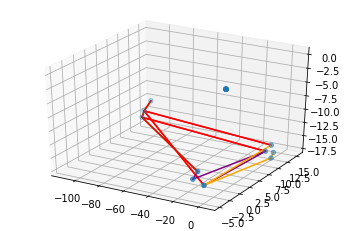

In [73]:
b_idx = 4 # batch_idx, recommended 4
s_idx = 4 # sample_idx, can change to plot different events

draw_3d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx]
            )

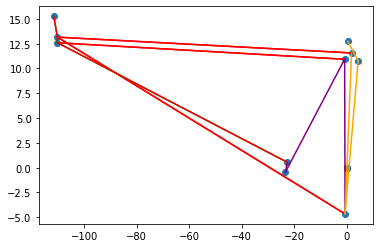

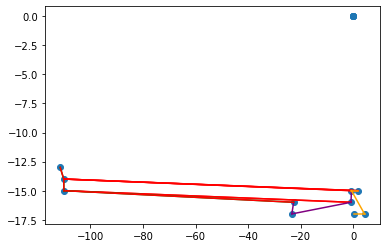

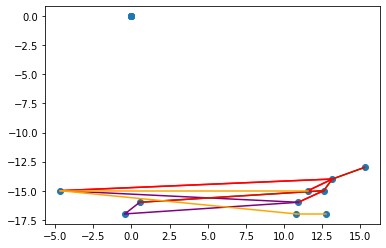

In [74]:
#XY
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 1))

#XZ
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 2))

#YZ
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(1, 2))